
### title: "Homework 3"
#### subtitle: ""
#### author: ""
#### date: ""

**Due:** end of day Saturday, February 4

**Submission instructions:** Submit one write-up per group on [gradescope.com](gradescope.com). 

**IMPORTANT:** 

- Write names of everyone that worked on the assignment on the submission.
- Specify every member of the group when submitting on Gradescope    
  (https://help.gradescope.com/article/m5qz2xsnjy-student-add-group-members)

For this homework, we will be using the case _Retention Modeling at Scholastic Travel Company_. Read:

- Case: Retention Modeling at Scholastic Travel Company (A);
- Supplement: Retention Modeling at Scholastic Travel Company (B);

which are available on Canvas.

Your goal is to help David build a model for retention. 

The following code will get you started.

# Load relevant libraries 

In [736]:
# First we import the necessary libraries
import os
import pandas as pd
pd.set_option("display.precision", 4)
import numpy as np
from datetime import datetime
from datetime import timedelta
from matplotlib import pyplot as plt
from sklearn.model_selection import GridSearchCV
import functools
from scipy import stats
import seaborn as sn
from sklearn.model_selection import LeavePOut
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import LeaveOneOut, cross_val_score
from sklearn.model_selection import train_test_split
from statsmodels.formula.api import ols
import scipy as sp
import plotnine as p9
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.filterwarnings("ignore")
import random 
import math
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
import statsmodels.api as sm
pd.options.display.float_format = '{:.4f}'.format
pd.options.mode.chained_assignment = None  # default='warn'
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

# Load the data

Here we will load the data from the CSV data file, 
examine its structure, and fix the data types 
incorrectly identified by R when importing from CSV.

In [737]:
STCdata_A = pd.read_csv('travelData.csv')
STCdata_A.set_index('ID', inplace=True)

You can use the function `str` to quickly check the internal structure of an R object.
Here we are using it to investigate type of data in each column of the loaded data.

In [738]:
STCdata_A.dtypes

Program.Code                       object
From.Grade                        float64
To.Grade                          float64
Group.State                        object
Is.Non.Annual.                      int64
Days                                int64
Travel.Type                        object
Departure.Date                     object
Return.Date                        object
Deposit.Date                       object
Special.Pay                        object
Tuition                             int64
FRP.Active                          int64
FRP.Cancelled                       int64
FRP.Take.up.percent.              float64
Early.RPL                          object
Latest.RPL                         object
Cancelled.Pax                       int64
Total.Discount.Pax                  int64
Initial.System.Date                object
Poverty.Code                       object
Region                             object
CRM.Segment                       float64
School.Type                       

Notice that some columns are identified as numerical or integer, but really the should be factors.

For instance, we have that column `From.Grade`

In [739]:
printmd(f'The number of unique data in From.Grade is **{len(STCdata_A["From.Grade"].unique())}**')

The number of unique data in From.Grade is **11**

only has 11 levels. It might be a better idea to treat it as a factor instead.

You can fix incorrectly classified data types as follows:

In [740]:
#convert the numerical column From.Grade to factor or categorical type
STCdata_A["From.Grade"] = STCdata_A["From.Grade"].astype('category')

We can check that indeed the column represents a factor:

In [741]:
#check the type of From.Grade
STCdata_A.dtypes[1:2]

From.Grade    category
dtype: object

Fix other columns that are numeric at the moment, but could be converted to factors.
The following line first finds numeric columns and then identifies the number of unique elements in each one.

In [742]:
numeric_cols = STCdata_A.select_dtypes(include=['int64', 'float64']).columns

unique_values = [len(STCdata_A[col].unique()) for col in numeric_cols]

cols_to_convert = numeric_cols[np.array(unique_values) <= 15]

In [743]:
cols_to_convert

Index(['To.Grade', 'Is.Non.Annual.', 'Days', 'CRM.Segment',
       'Parent.Meeting.Flag', 'MDR.High.Grade', 'School.Sponsor',
       'NumberOfMeetingswithParents', 'SingleGradeTripFlag',
       'Retained.in.2012.'],
      dtype='object')

Let us convert every column that has less than 15 unique values into a factor.
The following line identify names of such columns.

In [744]:
cols_to_convert

Index(['To.Grade', 'Is.Non.Annual.', 'Days', 'CRM.Segment',
       'Parent.Meeting.Flag', 'MDR.High.Grade', 'School.Sponsor',
       'NumberOfMeetingswithParents', 'SingleGradeTripFlag',
       'Retained.in.2012.'],
      dtype='object')

From this, we can see that the columns 
`To.Grade`, `Is.Non.Annual.`, `Days`,
`CRM.Segment`, `Parent.Meeting.Flag`, `MDR.High.Grade`, 
`School.Sponsor`, `NumberOfMeetingswithParents`, `SingleGradeTripFlag`
can be converted to factors.
We can also convert the output `Retained.in.2012.`

Convert these columns into factors.

In [745]:
# Convert columns in cols_to_convert to categorical
for col in cols_to_convert:
    STCdata_A[col] = STCdata_A[col].astype('category')

Now let's take care of date columns.

In [746]:
date_columns = ['Departure.Date', 'Return.Date', 'Deposit.Date', 'Early.RPL', 'Latest.RPL', 'Initial.System.Date', 'FirstMeeting', 'LastMeeting']
# Convert columns in date_columns to datetime
for col in date_columns:
    STCdata_A[col] = pd.to_datetime(STCdata_A[col])

And finally we change all the character columns to factors as well.

In [747]:
#find the columns with 'object' type
object_cols = STCdata_A.select_dtypes(include=['object']).columns
len(object_cols)

20

In [748]:
STCdata_A = STCdata_A.apply(lambda x: x.astype('category') if x.dtype == 'object' else x)

Let's see what we have:

In [749]:
STCdata_A.dtypes.to_frame()

,0
Program.Code,category
From.Grade,category
To.Grade,category
Group.State,category
Is.Non.Annual.,category
Days,category
Travel.Type,category
Departure.Date,datetime64[ns]
Return.Date,datetime64[ns]
Deposit.Date,datetime64[ns]


Pretty good!!!


# Data preprocessing

The data contains a number of columns with missing values.
Let's investigate. 
The following tells us the number of missing values in each column.

In [750]:
STCdata_A.to_clipboard()

In [751]:
#find number of missing values in each column
STCdata_A.isnull().sum().to_frame()

,0
Program.Code,0
From.Grade,127
To.Grade,150
Group.State,0
Is.Non.Annual.,0
Days,0
Travel.Type,0
Departure.Date,0
Return.Date,0
Deposit.Date,0


Dealing with missing values is a challenging problem, which could occupy a quarter of its own.
The purpose of this homework is not to investigate in-depth approaches to dealing with missing values,
but rather to investigate classification. 
For that reason, we take the following simple approach. 

The function `fixNAs` below fixes missing values. 
The function defines reactions:

 - adds a new category "FIXED_NA" for a missing value of a categorical/factor variable;
 - fills zero value for a missing value of a numeric variable;
 - fills "1900-01-01" for a missing value of a date variable.

Then it loops through all columns in the dataframe, 
reads their types, and loops through all the values, 
applying the defined reaction to any missing data point. 
In addition, the function creates a surrogate dummy 
variable for each column containing at least one missing value
(for example, `Special.Pay_surrogate`), which takes a value 
of 1 whenever the original variable (`Special.Pay`) has a
missing value, and 0 otherwise.

In [752]:
def fixNAs(data_frame):
  # Define reactions to NAs
  integer_reac = 0
  factor_reac = "FIXED_NA"
  character_reac = "FIXED_NA"
  date_reac = pd.to_datetime("1900-01-01")
  
  for col in data_frame.columns:
    col_data = data_frame[col]
    if col_data.dtype in [int, float]:
      if pd.isnull(col_data).sum() > 0:
        data_frame[f"{col}_surrogate"] = (col_data.isna()).astype(int).astype(str)
        data_frame[col].fillna(integer_reac, inplace=True)
    elif col_data.dtype == object:
      if pd.isnull(col_data).sum() > 0:
        data_frame[f"{col}_surrogate"] = (col_data.isna()).astype(int).astype(str)
        data_frame[col].fillna(character_reac, inplace=True)
    elif col_data.dtype == 'datetime64[ns]':
      if pd.isnull(col_data).sum() > 0:
        data_frame[f"{col}_surrogate"] = (col_data.isna()).astype(int).astype(str)
        data_frame[col].fillna(date_reac, inplace=True)
    elif col_data.dtype == 'category':
      if pd.isnull(col_data).sum() > 0:
        #adds a new category "FIXED_NA" for a missing value of a categorical/factor variable
        data_frame[col].cat.add_categories('FIXED_NA', inplace=True)
        data_frame[f"{col}_surrogate"] = (col_data.isna()).astype(int).astype(str)
        data_frame[col].fillna(factor_reac, inplace=True)

  return data_frame

We apply the above defined function to our data frame.

In [753]:
STCdata_A = fixNAs(STCdata_A)

We can see that the columns do not have any missing values any more.

In [754]:
any(STCdata_A.isnull().sum() > 0)

False

Next, we combine the rare categories. Levels that do not occur often 
during training tend not to have reliable effect estimates 
and contribute to over-fit. 

Let us check for rare categories in the variable `Group.State`.

In [755]:
STCdata_A['Group.State'].value_counts().to_frame()

,Group.State
CA,718
TX,308
WA,147
IL,104
CO,89
MI,71
FL,62
OH,53
AZ,53
OR,51


<AxesSubplot:>

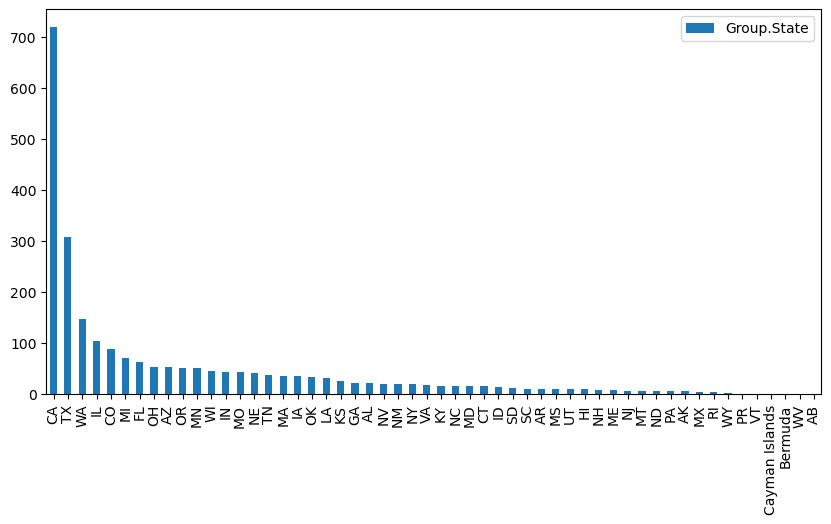

In [756]:
plt.rcParams['figure.figsize'] = [10, 5]
STCdata_A['Group.State'].value_counts().to_frame().plot(kind='bar')

Let us create a custom function to combine rare categories.
The function again loops through all the columns in the dataframe,
reads their types, and creates a table of counts 
for each level of the factor/categorical variables. All
levels with counts less than the `mincount` are combined into "other."
The function combines rare categories into "Other."+the name of the 
original variable (for example, `Other.State`).
This function has two arguments: 

- the name of the dataframe; and 
- the count of observations in a category to define "rare."


Let us combine categories with $<10$ values in `STCdata` into "Other."
Ultimately, it is going to depend on the person doing the analysis on what
they decide to call ``rare''.

In [757]:
def combine_rare_categories(data_frame, mincount):
    for column in data_frame.columns:
        if data_frame[column].dtype == "category":
            replace = data_frame[column].value_counts()[data_frame[column].value_counts() < mincount].index
            data_frame[column].replace(to_replace = replace, value = "Other." + column, inplace = True)
    return data_frame

In [758]:
STCdata_A = combine_rare_categories(STCdata_A, 10)

Let us look at `Group.State` again.

In [759]:
STCdata_A['Group.State'].value_counts().to_frame()

,Group.State
CA,718
TX,308
WA,147
IL,104
CO,89
Other.Group.State,82
MI,71
FL,62
AZ,53
OH,53


You can investigate other columns to see if everything looks fine.

# Split the data into training and testing sets

This is a very important step, both conceptually and technically.
Conceptually, because the goal of predictive modeling is not to build
a model that fits well the data it trains on, 
but rather one that would best predict the new data.
A test set is in this sense the best representation 
of what the "new data" may look like. Technically, to facilitate comparison
between different models, we need to maintain the same IDs in
the corresponding sets at all times.
We will accomplishes this through two "tricks": 

- a random seed ensures that the random-number generator 
  is initialized identically in each run; and 
- the `inTrain` vector is created once and can then be applied 
  anytime the data needs to be split. 
  
By default, the code sets 500 data points in the test set, 
and the remainder 1,889 into the training set.


In [784]:
df = pd.read_csv("STCdata_A.csv", index_col=0)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df = df.apply(le.fit_transform)

In [760]:
# #Change all the columns with _surrogate in the name to categorical
# for col in STCdata_A.columns:
#     if '_surrogate' in col:
#         STCdata_A[col] = STCdata_A[col].astype('category')

In [785]:
df_train, df_test = train_test_split(df, test_size = 500/len(STCdata_A), random_state=123)

Let us check that both the training and test sets have a similar
proportion of positive and negative cases.

In [786]:
print('Training set proportion:')
print(df_train['Retained.in.2012.'].value_counts(normalize=True))

print('Test set proportion:')
print(df_test['Retained.in.2012.'].value_counts(normalize=True))

Training set proportion:
1   0.6077
0   0.3923
Name: Retained.in.2012., dtype: float64
Test set proportion:
1   0.6060
0   0.3940
Name: Retained.in.2012., dtype: float64


# Fitting a logistic regression model

Let us fit a logistic regression model with all the variables included on the training set.

In [763]:
# import statsmodels.api as sm


# y = df_train["Retained.in.2012."].to_frame()

# X = df_train.drop("Retained.in.2012.", axis=1)

# logit_model = sm.GLM(y, X, family=sm.families.Binomial())
# # result = logit_model.fit()
# # print(result.summary())

In [787]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

y = df_train["Retained.in.2012."].values
X = df_train.drop("Retained.in.2012.", axis=1)

# X = pd.get_dummies(df_train.drop("Retained.in.2012.", axis=1))
# #convert datetime to integer
# for col in X.columns:
#     if X[col].dtype == 'datetime64[ns]':
#         X[col] = X[col].astype(int)
        
# #keep all the columns with _surrogate in the name and drop all the other columns with same name as the original column
# for col in X.columns:
#     if '_surrogate' in col:
#         X = X[X.columns.drop(list(X.filter(regex=col.replace('_surrogate', ''))))]



logit_model = LogisticRegression()
logit_model.fit(X, y)
logit_model

LogisticRegression()

In [788]:
y_pred = logit_model.predict(X)
from sklearn.metrics import confusion_matrix
print("Confusion Matrix:")
print(confusion_matrix(y, y_pred))

Confusion Matrix:
[[373 368]
 [212 936]]


The model is overfit. It has too many insignificant variables.

Let us fit a much simpler model. We will use stepwise regressions. 

Recall stepwise regression from BUS 41100 Applied regression course.
See, for example, [Week 9 slides](https://maxhfarrell.com/bus41100_old/).
You can also check Section 6.1.2 of the [ISLR](https://statlearning.com/) book.

There are three approaches to running stepwise regressions: backward, forward and both.
We need to specify criterion for inclusion/exclusion of variables.
We will use one based on Bayesian information criteria.

Observe the process of variables being added to the model,
(labeled by "+" in the output), gradual expansion of the model, 
and improvement of BIC.


In [ ]:
# Start from a null model with intercept only, and add one covarite at a time until maximum BIC.
lgfit.null <- glm(Retained.in.2012.~ 1, 
                 data=df.train, family="binomial")

lgfit.selected <- step(lgfit.null,                  # the starting model for our search
                       scope=formula(lgfit.all),    # the largest possible model that we will consider.
                       direction="forward", 
                       k=log(nrow(df.train)),       # by default step() uses AIC, but by
                                                    # multiplying log(n) on the penalty, we get BIC.
                                                    # See ?step -> Arguments -> k
                       trace=1)

In [782]:
import statsmodels.api as sm
import numpy as np

# Start from a null model with intercept only
df_train = df_train.astype(float)
X_train = sm.add_constant(np.ones(df_train.shape[0]))
y_train = df_train['Retained.in.2012.']
logit_model_null = sm.Logit(y_train, X_train)
result_null = logit_model_null.fit(disp=0)

# Add one covariate at a time until maximum BIC
# Prepare a full model with all covariates
X_full = sm.add_constant(df_train.drop('Retained.in.2012.', axis=1))
logit_model_full = sm.Logit(y_train, X_full)
result_full = logit_model_full.fit(disp=0)

# Calculate the BIC for each model in the sequence
bic_null = result_null.bic
bic_full = result_full.bic
bic_diff = bic_full - bic_null

# Select the best model by maximum BIC
selected_cols = []
for i in range(df_train.shape[1] - 1):
    bic_best = bic_diff.idxmin()
    selected_cols.append(bic_best)
    bic_diff = bic_diff.drop(bic_best)
    X_train = X_train.assign(**{bic_best: df_train[bic_best]})


ValueError: could not convert string to float: 'CD'

The algorithm stops once none of the 1-step expanded models lead to a lower BIC.

This is the selected model.

In [ ]:
summary(lgfit.selected)

You can predict probabilities from this model using the following.

In [ ]:
phat.lgfit.selected <- predict(lgfit.selected, 
                               newdata = df.test,
                               type = "response")

You will use these probabilities later.

While we are investigating variable selection in logistic regression models, 
let us also use a more modern approach to variable selection. We will 
use the lasso. 

If you have not seen this in BUS 41100 Applied regression course,
do not worry. We will provide more details in the Week 5.
You can also check Section 6.2.2 of the [ISLR](https://statlearning.com/) book.

I provide the code to fit a lasso logistic regression model.
We find coefficients $\beta$ that minimize the deviance
loss plus the penalty:
\[
-2\cdot\sum_{i=1}^n \log p(y_i, x_i; \beta) + \lambda \sum_{j=1}^p |\beta_j|.
\]
Here, $\lambda$ is the user chosen penalty that controls the flexibility of the fit.

First, we need to create a model matrix that will be used as an input to the package.

In [ ]:
X <- model.matrix(formula(lgfit.all), STCdata_A)
#need to subtract the intercept
X <- X[,-1]

X.train = X[ inTrain, ]
X.test = X[ -inTrain, ]

Next, we run 5-fold cross-validation.

In [ ]:
cv.l1.lgfit <- cv.glmnet(
  x       = X.train, 
  y       = df.train$Retained.in.2012.,
  family  = "binomial", 
  alpha   = 1,   #alpha=0 gives ridge regression
  nfolds  = 5)

We can plot the cross-validation curve, which shows us an estimate of out-of-sample deviance 
as a function of the tuning parameter $\lambda$.
The x-axis represents to $-\log(\lambda)$. 
Therefore, on the left we have large values of $\lambda$
and on the right we have small values of $\lambda$. 
At the top, you can see the number variables that were selected into the model.
The two vertical dashed lines correspond to $\lambda$ values that 
minimize the cross-validation error and 
the largest value of lambda such that error is within 1 standard error of the minimum.

In [ ]:
plot(cv.l1.lgfit, sign.lambda=-1)

Let us know plot the fitted coefficients as a function of $\lambda$.
Note that `cv.l1.lgfit$glmnet.fit` corresponds to a fitted glmnet object for the full data.

In [ ]:
glmnet.fit <- cv.l1.lgfit$glmnet.fit
plot(glmnet.fit, xvar = "lambda")
abline(v = log(cv.l1.lgfit$lambda.min), lty=2, col="red")
abline(v = log(cv.l1.lgfit$lambda.1se), lty=2, col="green")
legend("topright", legend=c("min", "1se"), lty=2, col=c("red", "green"))

For our predictive model, we will use 1 standard error $\lambda$.
Below you can see the variables that are selected by the lasso.

In [ ]:
betas <- coef(cv.l1.lgfit, s = "lambda.1se")
model.1se <- which(betas[2:length(betas)]!=0)
colnames(X[,model.1se])

We now use our model to predict probabilities on the test set.

In [ ]:
phat.l1.lgfit <- predict(glmnet.fit,
                         newx = X.test,
                         s = cv.l1.lgfit$lambda.1se,
                         type = "response")

# Questions

## How well does logistic regression do?

1. Create a confusion matrix for two logistic regression models build above.
   Use probabilities `phat.lgfit.selected` and `phat.l1.lgfit` to do so.
   
   To solve this question, you need to make a major decision. 
   What should the cutoff or "threshold" for the probability be,
   above which you will label a customer as being classified as "retained?"
   In our case, the data is slightly unbalanced---about 60.72% of data points are in Class 1.
   For very unbalanced data, we would first need to balance it (over- or under-sample).
   In this case, the benefits of balancing are unclear, hence one can implement 
   the average probability of being retained as a cutoff. 
   
   Predict classification using 0.6072 threshold.
   
   What can we see from the confusion matrices?
   
2. Plot ROC curves for the two classifiers and report the area under the curve.

   Note that the AUC of an error-free classifier would be 100%, 
   and an AUC of a random guess would be 50%. For values in-between,
   we can think of AUC as follows:
   
   - 90%+ = excellent,
   - 80–90% = very good, 
   - 70–80% = good, 
   - 60–70% = so-so, and
   - below 60% = not much value.

3. Plot lift curves for the two classifiers.

4. Create the profit curve (the amount of net profit vs the number 
   of groups targeted for promotion) for the two classifiers. 
   Suppose that the benefit of retaining a group is $100, 
   while the cost of a promotion is $40. 
   
   How many groups should be targeted to maximize the profit?
   
   How would this number change as the ratio between the benefit and cost changes?

   You can refer to the following code that plots a profit curve:   
   ```{r}
  # Function to plot a profit curve
  #
  # Inputs:
  #  - benefitTP(FN/FP/TN): the net benefit for a true positive (false negative,...)
  #      which is positive for a gain, and negative for a loss
  #  - y: vector of true labels, which has to be labeled as "0" and "1"
  #  - phat: vector of predicted probabilities
  # Outputs:
  #    the function returns the profit curve
  
  ProfitCurve <- function(benefitTP, benefitFN, benefitFP, benefitTN, y, phat){
    
    if(length(y) != length(phat)) stop("Length of y and phat not identical")
    if(length(levels(y))!=2 | levels(y)[1]!="0" | levels(y)[2]!="1")
      stop("y should be a vector of factors, only with levels 0 and 1")
    
    n <- length(y)
    df <- data.frame(y, phat)
    # Order phat so that we can pick the k highest groups for promotion
    df <- df[order(df[,2], decreasing = T),]
    TP <- 0; FP <- 0; FN <- table(y)[2]; TN <- table(y)[1]
    
    # Initializing the x and y coordinates of the plot
    ratio.vec <- seq(0,n)/n
    profit.vec <- rep(0,n+1)
    profit.vec[1] <- FN * benefitFN + TN * benefitTN
    
    for(k in 1:n){ # k is the number of groups classified as "YES"
      # In every round, we are picking one more group for promotion.
      # If this group was ratained (positive), then in this round, it is classified
      # as a "YES" instead of "NO" before. The confusion matrix is updated each round
      # with one more TP, and one less FN. It's similar when the group was not ratained.
      if(df[k,1]=="1"){TP <- TP + 1; FN <- FN - 1}
      else{FP <- FP + 1; TN <- TN - 1}
      #print(paste(TP, FP, TP-FP, benefitTP, benefitFP))
      profit.vec[k+1] <- TP*benefitTP + FP*benefitFP + FN*benefitFN + TN*benefitTN
    }
    
    plt <- plot(ratio.vec, profit.vec, type="l", lwd=2, col=4, main="Profit Curve",
                xlab="Percentage of Targetted Groups", ylab="Profit")
    abline(b=(profit.vec[n+1]-profit.vec[1]), a=profit.vec[1], lty=2) #Random guess
    return(plt)
  }
  ```

5. Develop a decision tree, random forest, and a boosting model using the training data.
   
   Report ROC, AUC, lift, and profit curves for these models.
   
   How do these methods compare to the logistic regression models?
   
6. Investigate whether David can improve performance of his models using    
   data he received from Emily.
   
   Note that in order to ensure true apples-to-apples comparison, you should
   use the same split of data into train and test.
   
   You can load and merge data as follows. 
   ```{r}
   STCdata_A <- read.csv('travelData.csv')
   STCdata_B <- read.csv('travelData_supplement.csv')
   STCdata_merged = merge(STCdata_A, STCdata_B, by = 'ID')
   STCdata_merged <- STCdata_merged[,-1]
   ```
   Remember to fix missing values and combine rare categories.
   
   Comment on the improvement (or lack thereof) from incorporating the NPS data.
